In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, Ridge

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv')
data.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [3]:
columns_to_use = [
    'Make',
    'Model',
    'Year',
    'Engine HP',
    'Engine Cylinders',
    'Transmission Type',
    'Vehicle Style',
    'highway MPG',
    'city mpg',
    'MSRP'
    ]
data = data[columns_to_use]

# Data preparation
* Select only the features from above and transform their names using next line:

In [4]:
data.columns = data.columns.str.replace(' ', '_').str.lower()

* Fill in the missing values of the selected features with 0:

In [5]:
missing_values = data.isna().sum()
print("Columns with missing values:")
print(missing_values[missing_values > 0])

data.fillna(0.0, inplace=True)

Columns with missing values:
engine_hp           69
engine_cylinders    30
dtype: int64


* Rename MSRP variable to price.

In [6]:
data.rename(columns={'msrp': 'price'}, inplace=True)

In [7]:
data.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,price
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


# Question 1
What is the most frequent observation (mode) for the column transmission_type?

AUTOMATIC           8266
MANUAL              2935
AUTOMATED_MANUAL     626
DIRECT_DRIVE          68
UNKNOWN               19
Name: transmission_type, dtype: int64


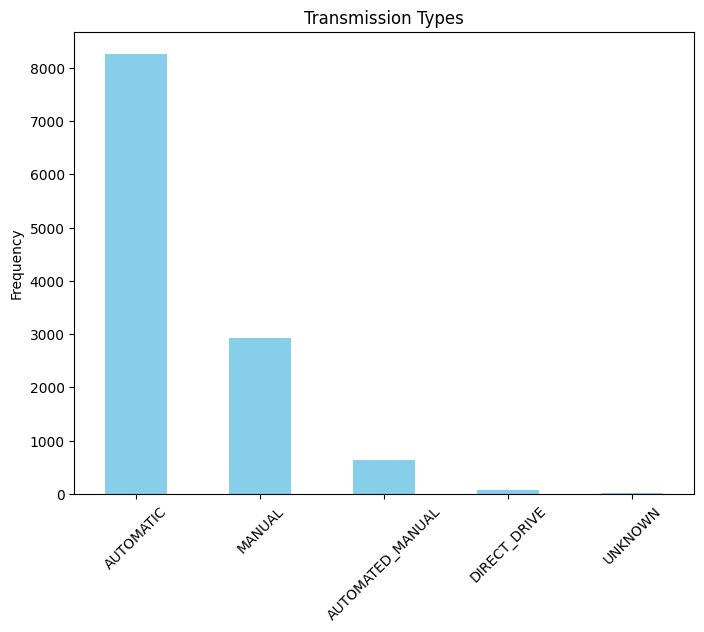

In [8]:
transmission_counts = data['transmission_type'].value_counts()

plt.figure(figsize=(8, 6))
transmission_counts.plot(kind='bar', color='skyblue')
plt.ylabel('Frequency')
plt.title('Transmission Types')
plt.xticks(rotation=45)
print(transmission_counts)
plt.show()

# Question 2
Create the correlation matrix for the numerical features of your dataset. In a correlation matrix, you compute the correlation coefficient between every pair of features in the dataset.

What are the two features that have the biggest correlation in this dataset?

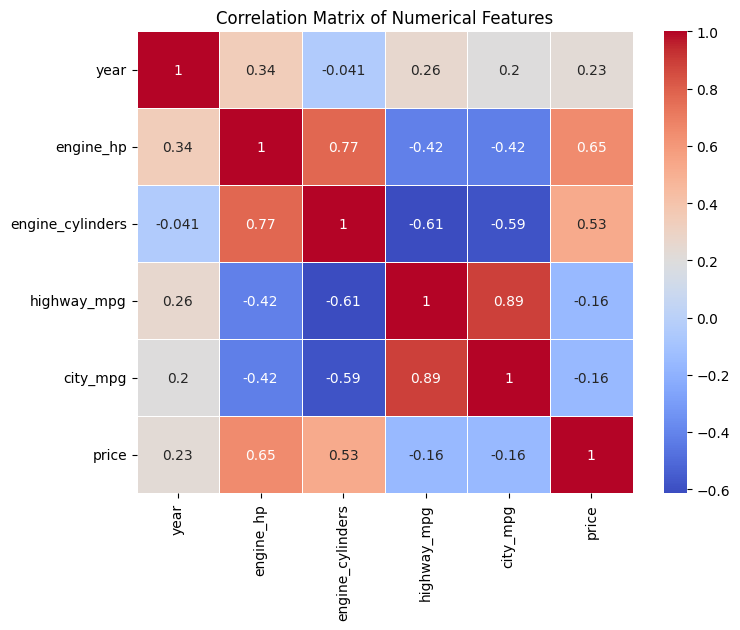

In [9]:
categorical_columns = ['make', 'model', 'transmission_type', 'vehicle_style']
numerical_columns = ['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

correlation_matrix = data[numerical_columns + ['price']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Make price binary
* Now we need to turn the price variable from numeric into a binary format.
* Let's create a variable above_average which is 1 if the price is above its mean value and 0 otherwise.

In [10]:
mean_price = data['price'].mean()
data.loc[:, 'above_average'] = (data['price'] > mean_price).astype(int)

# Split the data
* Split your data in train/val/test sets with 60%/20%/20% distribution.
* Use Scikit-Learn for that (the train_test_split function) and set the seed to 42.

In [11]:
train, val_test = train_test_split(data, test_size=0.4, random_state=42)
val, test = train_test_split(val_test, test_size=0.5)

# Question 3
* Calculate the mutual information score between above_average and other categorical variables in our dataset. Use the training set only.
* Round the scores to 2 decimals using round(score, 2).


In [12]:
print("Mutual Information between above_average and...")
for column in categorical_columns:
    mutual_info = mutual_info_score(train['above_average'], train[column])
    print(f'{column}: {round(mutual_info, 2)}')

Mutual Information between above_average and...
make: 0.24
model: 0.46
transmission_type: 0.02
vehicle_style: 0.08


# Question 4
* Now let's train a logistic regression.
* Remember that we have several categorical variables in the dataset. Include them using one-hot encoding.
* Fit the model on the training dataset.


    To make sure the results are reproducible across different versions of Scikit-Learn, fit the model with these parameters:


    model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)
* Calculate the accuracy on the validation dataset and round it to 2 decimal digits.

In [13]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_columns),  
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns) #https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
    ])

In [14]:
model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', model)
])
X_tr = train.iloc[:, :-2]
y_tr = train.iloc[:, -1]
pipeline.fit(X_tr, y_tr)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['year', 'engine_hp',
                                                   'engine_cylinders',
                                                   'highway_mpg', 'city_mpg']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['make', 'model',
                                                   'transmission_type',
                                                   'vehicle_style'])])),
                ('classifier',
                 LogisticRegression(C=10, max_iter=1000, random_state=42,
                                    solver='liblinear'))])

In [15]:
X_val = val.iloc[:, :-2]
y_val_pred = pipeline.predict(X_val)
y_val = val.iloc[:, -1]

accuracy = accuracy_score(y_val, y_val_pred)

print(f'Accuracy on validation set: {accuracy:.2f}')

Accuracy on validation set: 0.94


# Question 5
* Let's find the least useful feature using the feature elimination technique.
* Train a model with all these features (using the same parameters as in Q4).
* Now exclude each feature from this set and train a model without it. Record the accuracy for each model.
* For each feature, calculate the difference between the original accuracy and the accuracy without the feature.

In [16]:
print(f'original acc: {accuracy: .4f}')
print(f'Accuracy on validation set | original acc - new acc | removed feature')
for column in train.iloc[:, :-2].columns:
    cat_columns = [x for x in categorical_columns if x != column]
    num_columns = [x for x in numerical_columns if x != column]
    columns = cat_columns + num_columns

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', 'passthrough', num_columns),  
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_columns)
        ])

    model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    X_tr = train[columns]
    y_tr = train['above_average']
    pipeline.fit(X_tr, y_tr)

    X_val = val[columns]
    y_val = val['above_average']
    y_val_pred = pipeline.predict(X_val)

    accuracy_new = accuracy_score(y_val, y_val_pred)
    print(f'                    {accuracy_new:.4f} | {accuracy - accuracy_new :.4f}                  {column}')

original acc:  0.9425
Accuracy on validation set | original acc - new acc | removed feature
                    0.9169 | 0.0256                  make
                    0.9182 | 0.0243                  model
                    0.9475 | -0.0050                  year
                    0.9354 | 0.0071                  engine_hp
                    0.9425 | 0.0000                  engine_cylinders
                    0.9383 | 0.0042                  transmission_type
                    0.9173 | 0.0252                  vehicle_style
                    0.9413 | 0.0013                  highway_mpg
                    0.9421 | 0.0004                  city_mpg


# Question 6
* For this question, we'll see how to use a linear regression model from Scikit-Learn.
* We'll need to use the original column price. Apply the logarithmic transformation to this column.
* Fit the Ridge regression model on the training data with a solver 'sag'. Set the seed to 42.
* This model also has a parameter alpha. Let's try the following values: [0, 0.01, 0.1, 1, 10].
* Round your RMSE scores to 3 decimal digits.

In [17]:
train['price'] = train['price'].map(lambda x: np.log1p(x))
val['price'] = val['price'].map(lambda x: np.log1p(x))
test['price'] = test['price'].map(lambda x: np.log1p(x))

In [18]:
X_tr = train.iloc[:, :-2]
y_tr = train['price']
X_val = val.iloc[:, :-2]
y_val = val['price']

preprocessor = ColumnTransformer(
        transformers=[
            ('num', 'passthrough', numerical_columns),  
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
        ])

print(f'Accuracy on validation set | alpha')
print('----------------------------')
for alpha in [0, 0.01, 0.1, 1, 10]:

    model = Ridge(alpha=alpha, solver='sag', max_iter=1000, random_state=42)

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    pipeline.fit(X_tr, y_tr)
    y_val_pred = pipeline.predict(X_val)

    rmse_value = np.sqrt(mean_squared_error(y_val, y_val_pred))
    print(f'{rmse_value:.3f}                     | {alpha}')
    print('----------------------------')

Accuracy on validation set | alpha
----------------------------
0.252                     | 0
----------------------------
0.252                     | 0.01
----------------------------
0.252                     | 0.1
----------------------------
0.258                     | 1
----------------------------
0.334                     | 10
----------------------------
